In [1]:
from os import walk
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import load_model

import custom_loss_functions as cust_loss
from load_data import get_subset_ids, get_subset_sample_idx, DataGenerator_raw

Using TensorFlow backend.


In [2]:
def plot_history(hist, val_hist, metric_str):
    # plot train history
    plt.plot(hist)
    plt.plot(val_hist)
    plt.title('Model loss ('+metric_str+')')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

In [3]:
model_dir = 'models_trained/'
# load filelist
filelist = []
for (dirpath, dirnames, filenames) in walk(model_dir):
    filelist.extend(filenames)
filelist.sort()

In [4]:
filelist

['m1_bs4096_adam_msew_test-s18-s19-s20.h5',
 'm1_history.json',
 'm2_bs2048_adam_msaw_test-s18-s19-s20.h5',
 'm2_history.json',
 'm3_bs2048_adam_msaw_test-s18-s19-s20.h5',
 'm3_history.json',
 'm4_bs4096_adam_msew_test-s18-s19-s20.h5',
 'm4_history.json']

In [7]:
# load models and train history
model1 = load_model(model_dir + filelist[0], custom_objects={'mse_wrap_angle': cust_loss.mse_wrap_angle, 'mae_wrap_angle': cust_loss.mae_wrap_angle})
model2 = load_model(model_dir + filelist[2], custom_objects={'mse_wrap_angle': cust_loss.mse_wrap_angle, 'mae_wrap_angle': cust_loss.mae_wrap_angle})
model3 = load_model(model_dir + filelist[4], custom_objects={'mse_wrap_angle': cust_loss.mse_wrap_angle, 'mae_wrap_angle': cust_loss.mae_wrap_angle})
model4 = load_model(model_dir + filelist[6], custom_objects={'mse_wrap_angle': cust_loss.mse_wrap_angle, 'mae_wrap_angle': cust_loss.mae_wrap_angle})

with open(model_dir + filelist[1]) as json_file:
    history1 = json.load(json_file)
with open(model_dir + filelist[3]) as json_file:
    history2 = json.load(json_file)
with open(model_dir + filelist[5]) as json_file:
    history3 = json.load(json_file)
with open(model_dir + filelist[7]) as json_file:
    history4 = json.load(json_file)

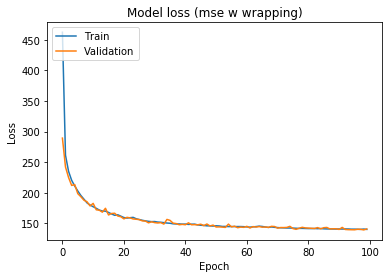

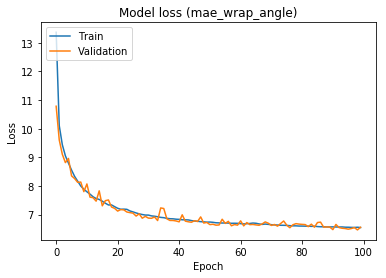

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 128)               12416     
_________________________________________________________________
dense_11 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 129       
Total params: 29,057
Trainable params: 29,057
Non-trainable params: 0
_________________________________________________________________


In [9]:
# model 1
plot_history(history1['loss'],history1['val_loss'],'mse w wrapping')
plot_history(history1['mae_wrap_angle'], history1['val_mae_wrap_angle'], 'mae_wrap_angle')

model1.summary()

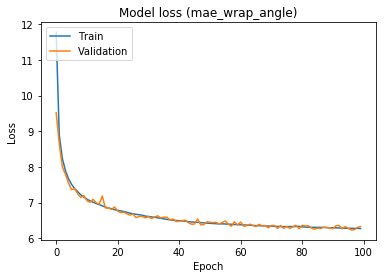

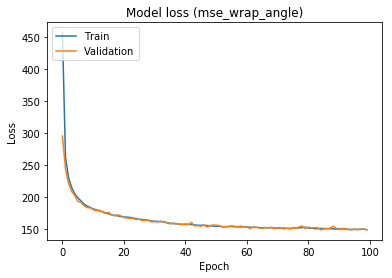

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               12416     
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 129       
Total params: 29,057
Trainable params: 29,057
Non-trainable params: 0
_________________________________________________________________


In [10]:
# model 2
plot_history(history2['loss'],history2['val_loss'],'mae_wrap_angle')
plot_history(history2['mse_wrap_angle'], history2['val_mse_wrap_angle'], 'mse_wrap_angle')

model2.summary()

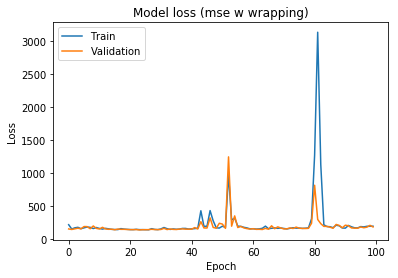

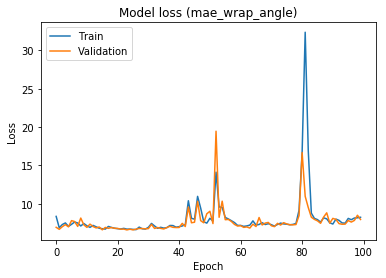

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 256)               24832     
_________________________________________________________________
dense_2 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_3 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 257       
Total params: 156,673
Trainable params: 156,673
Non-trainable params: 0
_________________________________________________________________


In [11]:
# model 3
plot_history(history3['loss'],history3['val_loss'],'mse w wrapping')
plot_history(history3['mae_wrap_angle'], history3['val_mae_wrap_angle'], 'mae_wrap_angle')

model3.summary()

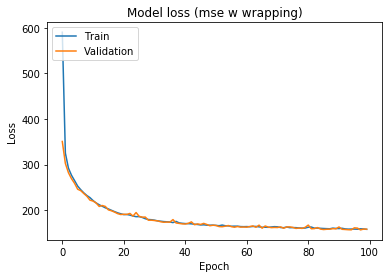

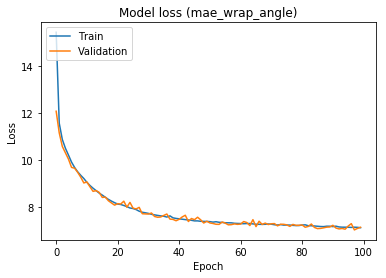

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 64)                6208      
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 10,433
Trainable params: 10,433
Non-trainable params: 0
_________________________________________________________________


In [12]:
# model 4
plot_history(history4['loss'],history4['val_loss'],'mse w wrapping')
plot_history(history4['mae_wrap_angle'], history4['val_mae_wrap_angle'], 'mae_wrap_angle')

model4.summary()

In [13]:
subset_test = ['subject_18', 'subject_19', 'subject_20']

# load data indices
ID_ref = pd.read_hdf('../generated/database_raw.h5', key='ID_reference_table')#.reset_index(drop=True)
ID_ref.set_index('global_id', drop=True, inplace=True)
list_IDs = ID_ref.index.values.astype(np.uint32)
n_samples = list_IDs.shape[0]
n_frames = 100

# load metadata
cond_table = pd.read_hdf('../generated/database_raw.h5', key='condition_table')
cond_table.set_index('cond_id', drop=True, inplace=True)

# only validate/train/test on samples specified by subset lists
cond_ids_test, pos_ids_test, subject_ids_test = get_subset_ids(subset_test, cond_table)
# extract repective samples from ID_ref table
list_IDs_test = get_subset_sample_idx(ID_ref, cond_ids_test, pos_ids_test, subject_ids_test)

#load data
target_data = pd.read_hdf('../generated/database_raw.h5', key='target_data')
feature_data = pd.read_hdf('../generated/database_raw.h5', key='feature_data')

In [21]:
# evaluate model1
params = {'dim': 96,
          'batch_size': 4096,
          'feature_data': feature_data.values,
          'target_data' : target_data.values,
          'shuffle': True,
          'n_frames': 100
         }

test_batch_generator = DataGenerator_raw(list_IDs_test, **params)
score = model1.evaluate_generator(test_batch_generator, verbose=1)
print('Test loss:', score[0])
print('Test mae w wrap:', score[1])
#print('Test mae w/o wrap:', score[2])

4218/4218 [==============================] - 661s 157ms/step
Test loss: 259.4977576417231
Test mae w wrap: 7.547765971699729


In [30]:
#predict on model1
X,y = test_batch_generator.__getitem__(4209)
pred = model1.predict_on_batch(X)

In [37]:
max(abs(pred[:].T - y[:]).T)

array([380.95030212])